# Simplified and Concise Explanation of the Challenge
## Objective:
To extract the chemical spectrum of exoplanet atmospheres using simulated data from the ARIEL mission, which includes observations of planetary transits.
ARIEL Mission: Observes exoplanets as they transit their stars.
### Dataset Overview:
Data collected includes time-series imagery from two instruments:
  * FGS1 (Fine Guidance System 1): Visible light (0.60–0.80 µm).
  * AIRS-CH0 (Infrared Spectrometer): Infrared (1.95–3.90 µm).
    
Key Characteristics:
* Data includes noise and is based on limited photon counts.
* Each planetary observation produces a large volume of images:
* FGS1: 135,000 frames, each 32x32 pixels.
* AIRS-CH0: 11,250 frames, each 32x356 pixels.
* Data files store flattened images requiring reshaping for analysis.
  
Hidden Test Set:
* Approximately 800 exoplanets in the test set.
* Includes some real exoplanet simulations (not scored).
  
### Data Components:
Signal Files:
* Time-series flux measurements during transits.
* Stored as .parquet files for both instruments (FGS1 and AIRS-CH0).

Calibration Files: Used to correct raw sensor data for noise and sensor irregularities.\
Types of calibration files:
* Dark Frames: Subtract thermal noise and bias levels.
* Dead Frames: Identify unresponsive (dead) or overly responsive (hot) pixels.
* Flat Frames: Correct pixel sensitivity variations.
* Linearity Correction: Adjust for non-linear pixel response at high charges.
* Read Noise Frames: Account for electronic noise during readout.
       
Metadata Files:
* ADC Info: Restores the original dynamic range of the data using gain and offset values.
* Axis Info: Provides temporal and spectral axis details for the time-series data.
* Wavelength Grid: Links spectra to wavelength ranges.
* Train Labels: Ground truth chemical spectra for the training data.


# First Step : Calibration 
The code for calibration is in the notebook: https://www.kaggle.com/code/irasharma/neurips/notebook?scriptVersionId=217626513 
which includes the following steps:

1. ADC Conversion: Convert digital signals back to analog form using gain and offset.
2. Bad Pixel Correction: Mask and correct hot and dead pixels using provided maps and dark frame data.
3. Non-Linearity Correction: Apply non-linearity corrections using spline interpolation for better signal accuracy.
4. Dark Current Removal: Subtract dark current while accounting for dead pixels.
5. CDS Calculation: Perform Correlated Double Sampling (CDS) by subtracting the start-of-exposure frames from the end-of-exposure frames.
6. Time Binning: Bin the data over specified time intervals for more efficient analysis.
7. Flat Field Correction: Correct signal using flat field data to adjust for pixel-to-pixel variations in the detector.
8. Index Extraction: Retrieve the indices of training data using file paths and split into chunks.
9. Chunk Processing: Process the data in chunks, applying various corrections (masking, non-linearity, dark current, flat field) based on configuration settings.
10. Data Preprocessing: Read and preprocess FGS1 and AIRS-CH0 signal and calibration data, applying corrections as specified (masking, dark current removal, etc.).
11. Final Output: Cleaned and calibrated signals as AIRS_clean_train_{planet_id}.npy and FGS_clean_train_{planet_id}.npy are stored for all 673 planets for further analysis or inference.


# Second Step: Analysis of the Calibrated FGS1 and AIRS-CHO Signals

In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm
import pickle
import itertools
import os
import glob
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
train_labels=pd.read_csv("/kaggle/input/ariel-data-challenge-2024/train_labels.csv")
train_labels

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,785834,0.001086,0.001137,0.001131,0.001124,0.001138,0.001131,0.001123,0.001127,0.001120,...,0.001075,0.001076,0.001076,0.001076,0.001074,0.001073,0.001072,0.001073,0.001073,0.001072
1,14485303,0.001835,0.001835,0.001834,0.001833,0.001833,0.001833,0.001833,0.001834,0.001834,...,0.001893,0.001892,0.001892,0.001891,0.001891,0.001891,0.001890,0.001890,0.001889,0.001888
2,17002355,0.002792,0.002814,0.002808,0.002804,0.002809,0.002805,0.002802,0.002805,0.002801,...,0.002784,0.002783,0.002783,0.002783,0.002783,0.002784,0.002784,0.002785,0.002785,0.002784
3,24135240,0.001294,0.001308,0.001308,0.001306,0.001306,0.001303,0.001306,0.001314,0.001314,...,0.001405,0.001404,0.001403,0.001402,0.001401,0.001400,0.001399,0.001397,0.001395,0.001393
4,25070640,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,...,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,4249337798,0.000790,0.000828,0.000825,0.000822,0.000830,0.000826,0.000822,0.000823,0.000820,...,0.000798,0.000799,0.000799,0.000799,0.000798,0.000796,0.000796,0.000796,0.000796,0.000796
669,4257395405,0.004063,0.004094,0.004090,0.004094,0.004083,0.004069,0.004076,0.004097,0.004100,...,0.004042,0.004042,0.004041,0.004041,0.004041,0.004041,0.004041,0.004040,0.004040,0.004039
670,4266129805,0.006566,0.006569,0.006568,0.006568,0.006567,0.006567,0.006568,0.006570,0.006569,...,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566,0.006566
671,4273166473,0.005647,0.005700,0.005687,0.005676,0.005687,0.005676,0.005667,0.005673,0.005663,...,0.005603,0.005603,0.005603,0.005602,0.005602,0.005604,0.005606,0.005607,0.005607,0.005605


In [3]:
import os

# Define the path to the dataset directory
dataset_path = '/kaggle/input/long-run-neurips/data_light_raw'

# List all files in the directory
files = os.listdir(dataset_path)

# Filter out the files that end with 'AIRS_clean_train_' and '.npy'
airs_clean_files = [file for file in files if file.startswith('AIRS_clean_train_')]
fgs_clean_files = [file for file in files if file.startswith('FGS1_train_')]
# Display the number of matching files
print(f"Number of AIRS_clean_train_ files: {len(airs_clean_files)}")
print(f"Number of FGS_clean_train_ files: {len(fgs_clean_files)}")
# print(f"Files found: {airs_clean_files}")

Number of AIRS_clean_train_ files: 673
Number of FGS_clean_train_ files: 673


### AIRS-CH0 Calibrated Signal Visualization

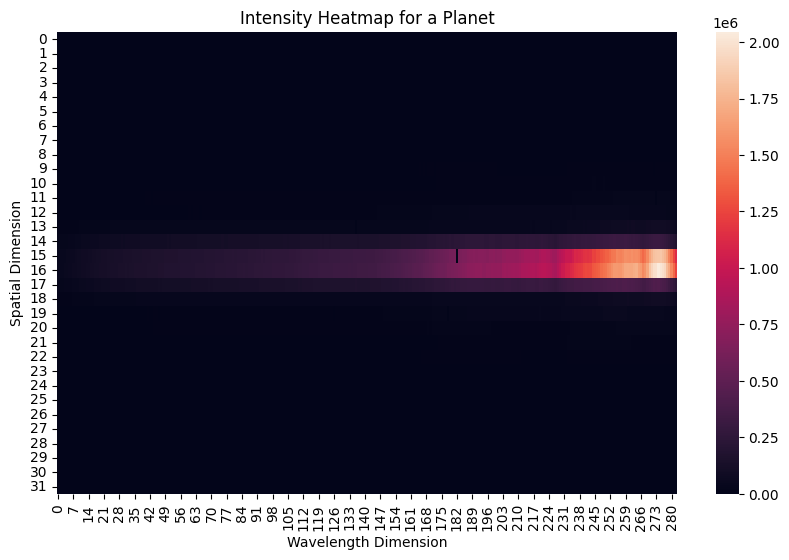

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))

# Iterate over the first 5 planets
for planet_id in train_labels['planet_id'].values[:1]:
    # Construct the file path
    file_path = f"/kaggle/input/long-run-neurips/data_light_raw/AIRS_clean_train_{planet_id}.npy"
    
    # Load the data for the planet
    data = np.load(file_path)[0]
    
    # Replace NaN values with 0
    data[np.isnan(data)] = 0
    
    # Plot the heatmap on top of others
    sns.heatmap(data[0, :, :].T, cbar=True)

# Customize the plot
plt.title("Intensity Heatmap for a Planet")
plt.ylabel('Spatial Dimension')
plt.xlabel('Wavelength Dimension')
plt.show()



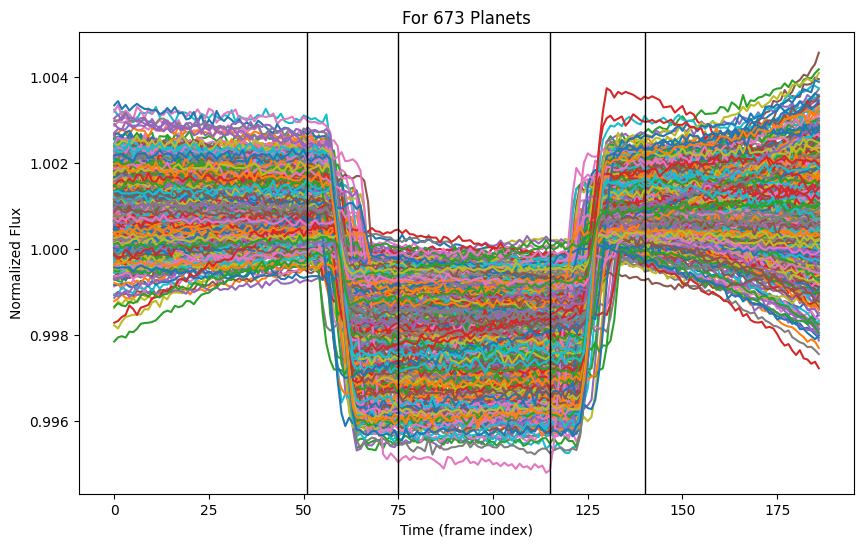

In [5]:
# Brightness Variation Information Showing the Approximate In-Transit and Out-Transit Regions

plt.figure(figsize=(10, 6))

# Iterate for all the planets
for planet_id in train_labels['planet_id'].values[:]:
    # Construct the file path
    file_path = f"/kaggle/input/long-run-neurips/data_light_raw/AIRS_clean_train_{planet_id}.npy"
    
    # Load the data for the planet
    data = np.load(file_path)[0]
    
    # Replace NaN values with 0
    data[np.isnan(data)] = 0
    
    # Sum over the wavelength 
    series = data.sum(axis=1).sum(axis=1)

    plt.plot(series/series.mean())

for time_step in [51, 75, 115, 140]:
   plt.axvline(time_step, color='black', linewidth=1)
plt.title("For 673 Planets")
plt.xlabel("Time (frame index)")
plt.ylabel("Normalized Flux")
plt.show()


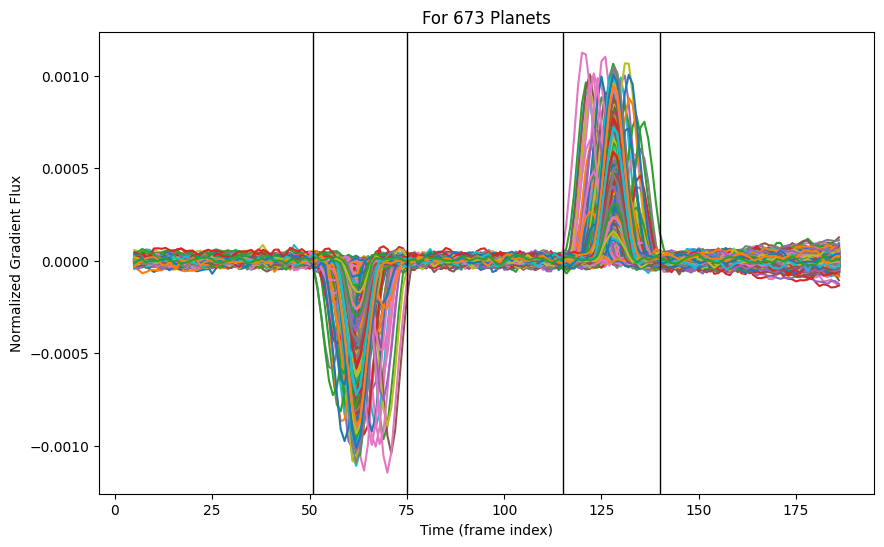

In [6]:
# Smoothened Gradient showing the Approximate Transition Points

plt.figure(figsize=(10, 6))

# Iterate for all the planets
for planet_id in train_labels['planet_id'].values[:]:
    # Construct the file path
    file_path = f"/kaggle/input/long-run-neurips/data_light_raw/AIRS_clean_train_{planet_id}.npy"
    
    # Load the data for the planet
    data = np.load(file_path)[0]
    
    # Replace NaN values with 0
    data[np.isnan(data)] = 0
    
    # Sum over the wavelength 
    tsignal=pd.Series(data.sum(axis=1).sum(axis=1)).rolling(window=5).sum()
    gsignal=np.gradient(tsignal/tsignal.max())

    plt.plot(gsignal)

for time_step in [51, 75, 115, 140]:
   plt.axvline(time_step, color='black', linewidth=1)
plt.title("For 673 Planets")
plt.xlabel("Time (frame index)")
plt.ylabel("Normalized Gradient Flux")
plt.show()

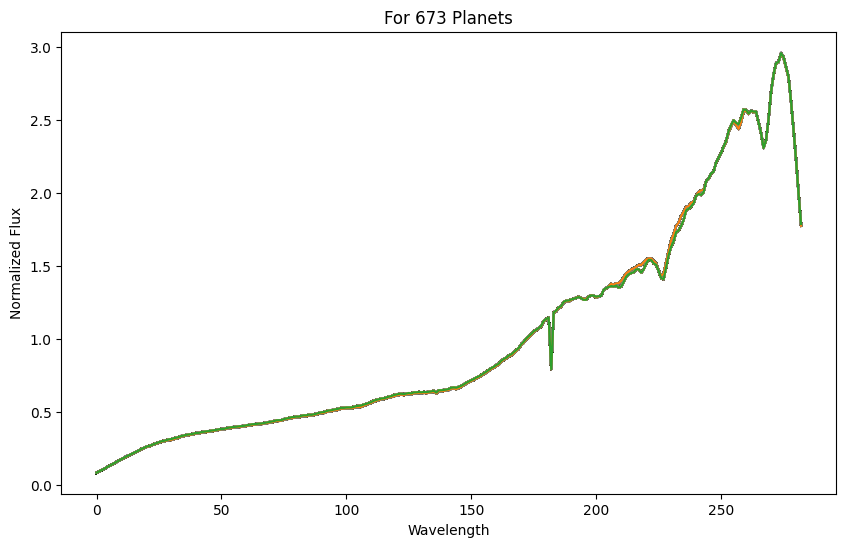

In [7]:
# Spectral Information showing the absorption dips

plt.figure(figsize=(10, 6))

# Iterate for all the planets
for planet_id in train_labels['planet_id'].values[:]:
    # Construct the file path
    file_path = f"/kaggle/input/long-run-neurips/data_light_raw/AIRS_clean_train_{planet_id}.npy"
    
    # Load the data for the planet
    data = np.load(file_path)[0]
    
    # Replace NaN values with 0
    data[np.isnan(data)] = 0
    
    # Sum over the time frame
    series = data.sum(axis=0).sum(axis=1)

    plt.plot(series/series.mean())

# Customize the plot
plt.title("For 673 Planets")
plt.xlabel("Wavelength")
plt.ylabel("Normalized Flux")
plt.show()

### FGS1 Calibrated Signal Visualization

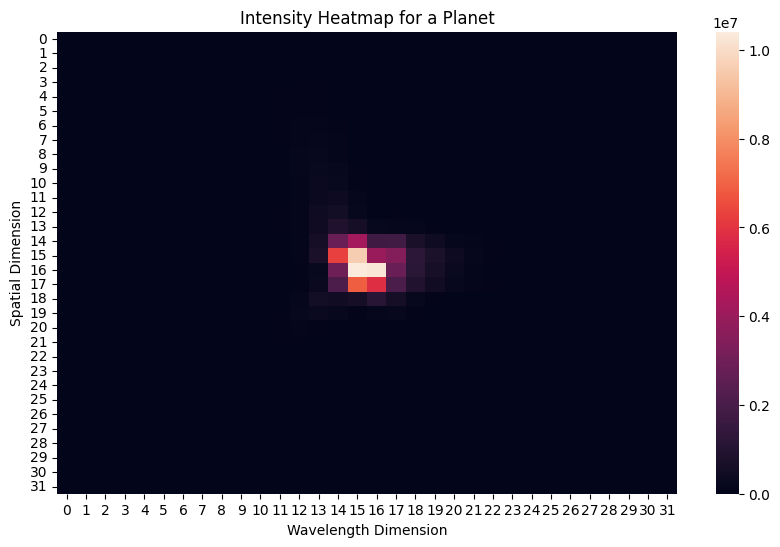

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))

# Iterate over the first 5 planets
for planet_id in train_labels['planet_id'].values[:1]:
    # Construct the file path
    file_path = f"/kaggle/input/long-run-neurips/data_light_raw/FGS1_train_{planet_id}.npy"
    
    # Load the data for the planet
    data = np.load(file_path)[0]
    
    # Replace NaN values with 0
    data[np.isnan(data)] = 0
    
    # Plot the heatmap on top of others
    sns.heatmap(data[0, :, :].T, cbar=True)

# Customize the plot
plt.title("Intensity Heatmap for a Planet")
plt.ylabel('Spatial Dimension')
plt.xlabel('Wavelength Dimension')
plt.show()

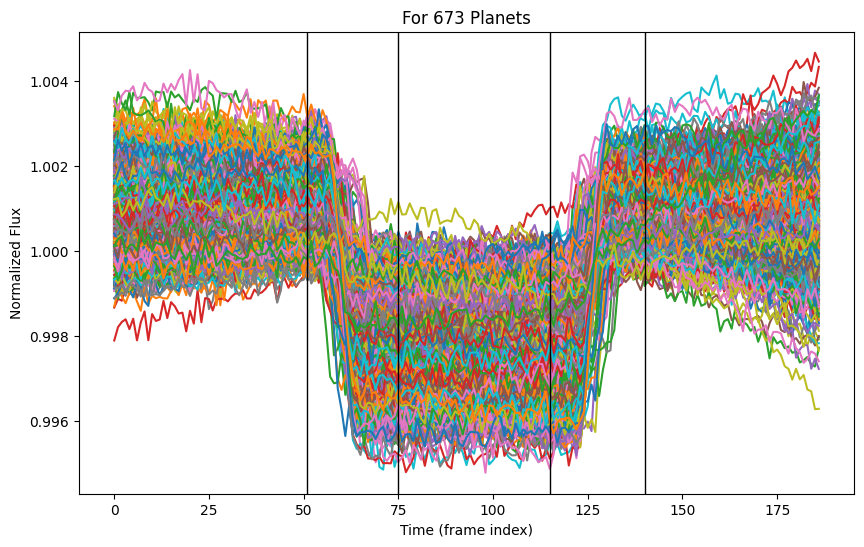

In [9]:
# Brightness Variation Information Showing the Approximate In-Transit and Out-Transit Regions

plt.figure(figsize=(10, 6))

# Iterate for all the planets
for planet_id in train_labels['planet_id'].values[:]:
    # Construct the file path
    file_path = f"/kaggle/input/long-run-neurips/data_light_raw/FGS1_train_{planet_id}.npy"
    
    # Load the data for the planet
    data = np.load(file_path)[0]
    
    # Replace NaN values with 0
    data[np.isnan(data)] = 0
    
    # Sum over the wavelength 
    series = data.sum(axis=1).sum(axis=1)

    plt.plot(series/series.mean())

for time_step in [51, 75, 115, 140]:
   plt.axvline(time_step, color='black', linewidth=1)
plt.title("For 673 Planets")
plt.xlabel("Time (frame index)")
plt.ylabel("Normalized Flux")
plt.show()

# Third Step : Transit Analysis

Only the AIRS-CH0 data is used for the Transit analysis because it encompasses both the required brightness intensity dips and spectral information. While the FGS1 data, which solely provides brightness variation details, is just supposed to be added as a single column later.

The code to find Transit Depth for all the 673 planets is in the notebook: https://www.kaggle.com/code/irasharma/transitdata-errors/notebook?scriptVersionId=217834937 which includes the following steps:

 File Management:
   * Extracts dataset IDs from files containing 'AIRS_clean_train_'.
   * Loads data files and replaces NaN values with 0.
     
 Light Curve Extraction:
   * Computes the total light intensity by summing data across axes.
   * Normalizes the light curve by its mean intensity.
     
 Detrending Using Taylor Series:

   * Models light curve trends using a Taylor series function: $ f(x) = a + b \cdot x + c \cdot x^2 + d \cdot x^3 $
   * Fits the function to the start and end regions of the light curve using curve_fit.
   * Detrends the light curve by dividing by the fitted model.

Transit Phase Identification:
   * Computes gradient to locate transit boundaries
   * Ingress (x_start): Minimum gradient.
   * Egress (x_end): Maximum gradient.

 Spectral Analysis:
   * Out-of-Transit Phases: Before ingress and after egress.
   * In-Transit Phase: Between ingress and egress.
   * Extracts and sums spectra for each phase.

 Output Management:
   * In-transit: /AIRS_spectrum_in_transit/.
   * Out-of-transit: /AIRS_spectrum_out_transit/.

# Fourth Step: Regression Training Model

In [10]:
in_data=np.load("/kaggle/input/transitdata-errors/1005054328/in_transit_spectrum_data.npy")
out_data= np.load("/kaggle/input/transitdata-errors/1005054328/out_transit_spectrum_data.npy")
planet_id = 1005054328  # Example planet ID as an integer

# Filter the DataFrame to get the row corresponding to this planet_id
planet_data = train_labels[train_labels['planet_id'] == planet_id]

# Drop the 'planet_id' column, as you only need the wavelength columns
wavelength_data = planet_data.drop(columns=['planet_id'])


In [11]:
tr_data = []
# Iterate over the first 5 planets
for planet_id in tqdm(train_labels['planet_id'].values[:]):
    # Construct the file path
    in_data = np.load(f"/kaggle/input/transitdata-errors/{planet_id}/in_transit_spectrum_data.npy")
    out_data = np.load(f"/kaggle/input/transitdata-errors/{planet_id}/out_transit_spectrum_data.npy")
    transit_depth= (out_data-in_data)/out_data
    tr_data.append(transit_depth)

100%|██████████| 673/673 [00:12<00:00, 55.99it/s]


In [17]:
tr_data = np.array(tr_data)
train_data, val_data, train_label, val_label = train_test_split(tr_data, train_labels.values[:, 1:], \
                                                               test_size=0.4, shuffle=True)

# R2 score for Train Data: 0.980
# Root mean squared error for Train Data: 0.000254
# R2 score on Validation Data: 0.964
# Root mean squared error for Validation Data: 0.000301


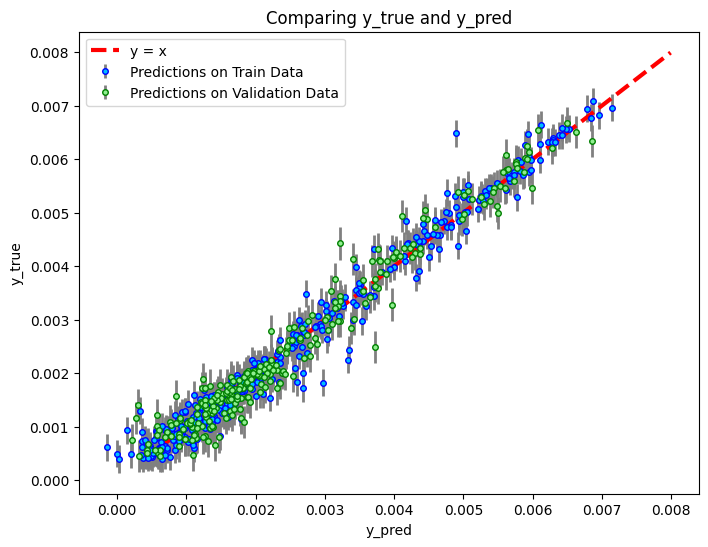

In [31]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Define Ridge regression model
model = Ridge(alpha=1E-3)

# Cross-validation predictions for train data
oof_pred = cross_val_predict(model, train_data, train_label)

# Calculate R2 score and RMSE for train data
print(f"# R2 score for Train Data: {r2_score(train_label, oof_pred):.3f}")
sigma_pred = mean_squared_error(train_label, oof_pred, squared=False)
print(f"# Root mean squared error for Train Data: {sigma_pred:.6f}")

# Cross-validation predictions for validation data
oof_pred_val = cross_val_predict(model, val_data, val_label)

# Calculate R2 score and RMSE for validation data
print(f"# R2 score on Validation Data: {r2_score(val_label, oof_pred_val):.3f}")
sigma_pred_val = mean_squared_error(val_label, oof_pred_val, squared=False)
print(f"# Root mean squared error for Validation Data: {sigma_pred_val:.6f}")

# Plotting
plt.figure(figsize=(8, 6))
col = 1  # Ensure this column exists in both train_label and val_label

# Error bar plot for train data
plt.errorbar(
    oof_pred[:, col], train_label[:, col], yerr=sigma_pred, 
    fmt='o', markersize=4, alpha=1, label='Predictions on Train Data', 
    color='deepskyblue', markeredgecolor='blue', ecolor='gray', elinewidth=2
)

# Error bar plot for validation data
plt.errorbar(
    oof_pred_val[:, col], val_label[:, col], yerr=sigma_pred_val, 
    fmt='o', markersize=4, alpha=1, label='Predictions on Validation Data', 
    color='lightgreen', markeredgecolor='green', ecolor='gray', elinewidth=2
)

# Reference line y = x
y_min = min(train_label.min(), val_label.min())
y_max = max(train_label.max(), val_label.max())
plt.plot([y_min, y_max], [y_min, y_max], color='red', linestyle='--', linewidth=3, label='y = x')

# Labels, title, and legend
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.legend()
plt.show()
